# Extreme Gradient Boost


### Initialization

In [3]:

from xgboost import XGBRegressor
import xgboost as xgb
from utility import start
from utility import train
from utility import display

X_train, X_test, y_train, y_test, df = start("encoded_data_04_18.csv")
df.shape

(21226, 17)

In [10]:
#model = XGBRegressor(n_estimators=2000, max_depth=10, random_state=42, learning_rate=0.25, tree_method="hist")
#odel = xgb()
# Defining hyperparameters for XGBoost
params = {
    'objective': 'reg:absoluteerror',  # for regression
    'max_depth': 7,                    # maximum depth of a tree
    'learning_rate': 0.25,              # learning rate
    'n_estimators': 5000,              # number of trees
    'gamma': 0.9,                      # regularization parameter
    'subsample': 0.8,                  # subsample ratio of the training instances
    'colsample_bytree': 0.8,           # subsample ratio of columns when constructing each tree
    'min_child_weight': 1,             # minimum sum of instance weight needed in a child
}

# Instantiating the XGBoost regressor
model = xgb.XGBRegressor(**params)

y_pred, y_pred_original, y_test_original, y_train_pred_original, _, _ = train(model, X_train, X_test, y_train, y_test)
#1.51, 41% - 1.76, 49%

Training Set Scores:
Mean Absolute Error (MAE): 0.31 M
Mean Absolute Percentage Error (MAPE): 23.42 %

Test Set Scores:
Mean Absolute Error (MAE): 0.99 M
Mean Absolute Percentage Error (MAPE): 54.18 %


Training Set Scores:
Mean Absolute Error (MAE): 0.15 M
Mean Absolute Percentage Error (MAPE): 8.64 %

Test Set Scores:
Mean Absolute Error (MAE): 1.0 M
Mean Absolute Percentage Error (MAPE): 57.87 %

In [ ]:
results, z = display(df, X_test, y_pred)
results


,name,year,market_value_in_eur,Predicted_Value
2265,Federico Valverde,2023.75,100000000.0,9.929628e+07
4771,Leroy Sané,2023.75,80000000.0,1.945563e+08
3226,Alphonso Davies,2023.75,70000000.0,8.950889e+07
7110,Nuno Mendes,2023.25,65000000.0,9.830350e+06
3323,Jules Koundé,2023.75,60000000.0,2.395930e+07
...,...,...,...,...
15616,Givan Werkhoven,2017.25,25000.0,2.964770e+05
11552,Aleksey Kornienko,2020.25,25000.0,2.075699e+05
15164,Ahmet Sahin,2017.75,25000.0,1.380110e+05
13894,Aleksandr Kharitonov,2018.75,25000.0,1.373338e+05


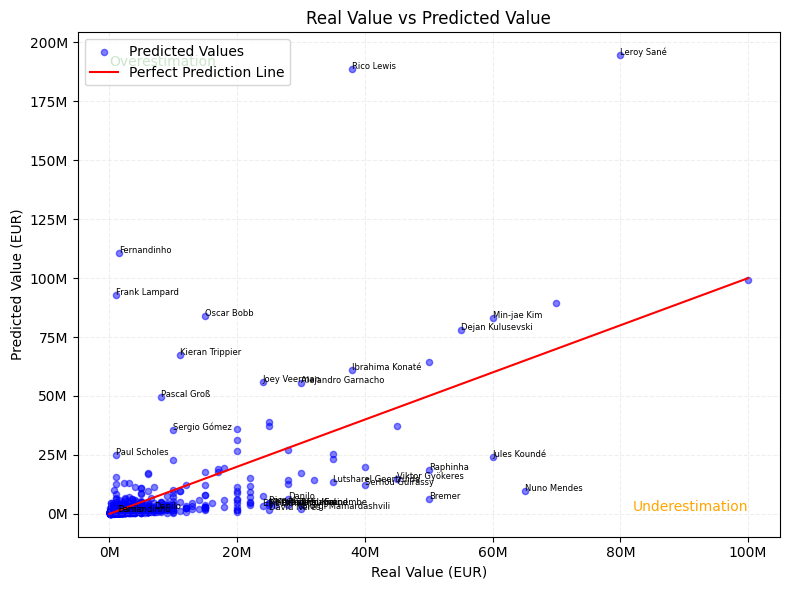

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
# Calculate distances of each point from the optimal line
distances = np.abs(y_pred_original - y_test_original)

# Find the indices of points with maximum distances
max_distance_indices = np.argsort(distances)[-30:]  # Adjust the number to show more or fewer names

# Get the corresponding player names
furthest_names = z.iloc[max_distance_indices]['name'].tolist()

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, y_pred_original, s=20, color='blue', alpha=0.5, marker='o', label='Predicted Values')
plt.xlabel("Real Value (EUR)")
plt.ylabel("Predicted Value (EUR)")
plt.title("Real Value vs Predicted Value")
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], color='red', label='Perfect Prediction Line')
plt.text(min(y_test_original), max(y_pred_original), "Overestimation", fontsize=10, color='green', verticalalignment='top', horizontalalignment='left')
plt.text(max(y_test_original), min(y_pred_original), "Underestimation", fontsize=10, color='orange', verticalalignment='bottom', horizontalalignment='right')

# Annotate only the furthest points
for index, row in z.iterrows():
    if row['name'] in furthest_names:
        plt.annotate(row['name'], (row['market_value_in_eur'], row['Predicted_Value']), fontsize=6, color='black')

# Set formatter for x-axis and y-axis
def millions_formatter(x, pos):
    return f'{x / 1000000:.0f}M'

formatter = FuncFormatter(millions_formatter)
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)

plt.grid(alpha=0.2, linestyle='--', zorder=1)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
y_train.shape
y_train_original = np.power(10, y_train)
y_train_original.shape
print(y_train_original.shape, y_train_pred_original.shape)

(19103,) (19103,)


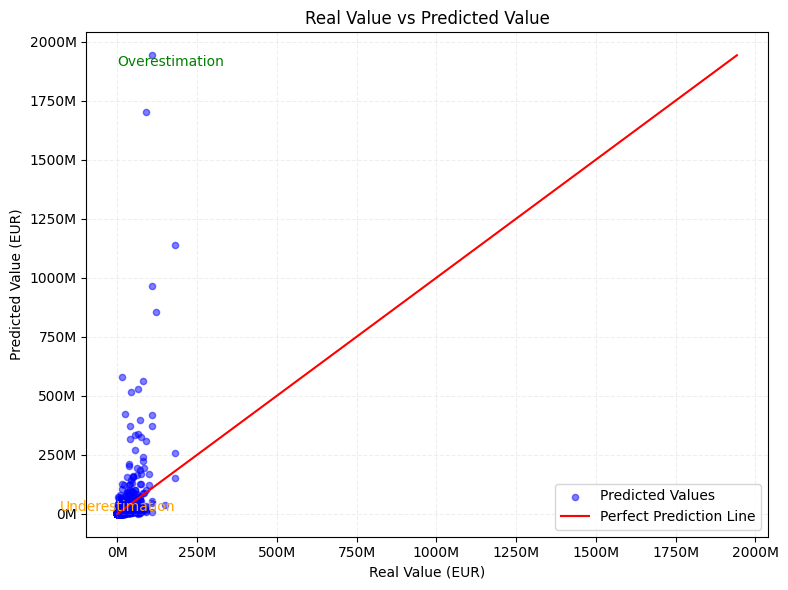

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
# Calculate distances of each point from the optimal line

y_train_original = np.power(10, y_train)
distances = np.abs(y_train_pred_original - y_train_original)

# Find the indices of points with maximum distances
max_distance_indices = np.argsort(distances)[-10:]  # Adjust the number to show more or fewer names

# Get the corresponding player names
#furthest_names = z.iloc[max_distance_indices]['name'].tolist()

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_train_original, y_train_pred_original, s=20, color='blue', alpha=0.5, marker='o', label='Predicted Values')
plt.xlabel("Real Value (EUR)")
plt.ylabel("Predicted Value (EUR)")
plt.title("Real Value vs Predicted Value")
plt.plot([min(y_train_pred_original), max(y_train_pred_original)], [min(y_train_pred_original), max(y_train_pred_original)], color='red', label='Perfect Prediction Line')
plt.text(min(y_train_original), max(y_train_pred_original), "Overestimation", fontsize=10, color='green', verticalalignment='top', horizontalalignment='left')
plt.text(max(y_train_original), min(y_train_pred_original), "Underestimation", fontsize=10, color='orange', verticalalignment='bottom', horizontalalignment='right')

# Annotate only the furthest points
#for index, row in z.iterrows():
#    if row['name'] in furthest_names:
#        plt.annotate(row['name'], (row['market_value_in_eur'], row['Predicted_Value']), fontsize=6, color='black')

# Set formatter for x-axis and y-axis
def millions_formatter(x, pos):
    return f'{x / 1000000:.0f}M'

formatter = FuncFormatter(millions_formatter)
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)

plt.grid(alpha=0.2, linestyle='--', zorder=1)
plt.legend()
plt.tight_layout()
plt.show()


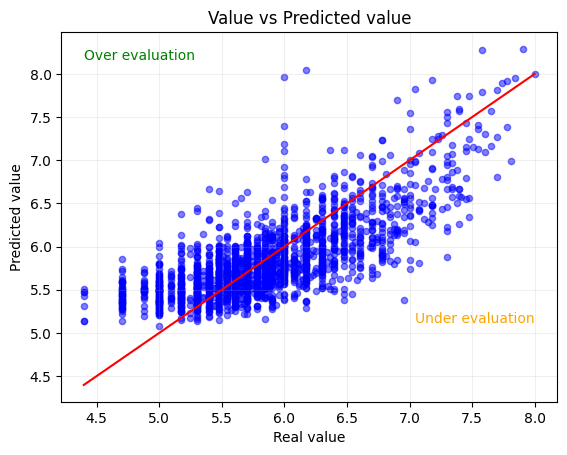

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot
plt.scatter(y_test, y_pred, s=20, color='blue', alpha=0.5)  # Set dot size to 20, blue color, and transparency to 0.5
plt.xlabel("Real value")
plt.ylabel("Predicted value")
plt.title("Value vs Predicted value")

# Add diagonal line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.text(min(y_test), max(y_pred), "Over evaluation", fontsize=10, color='green', verticalalignment='top', horizontalalignment='left')
plt.text(max(y_test), min(y_pred), "Under evaluation", fontsize=10, color='orange', verticalalignment='bottom', horizontalalignment='right')
plt.grid(alpha=0.2, zorder=1)

plt.show()


10000000.0


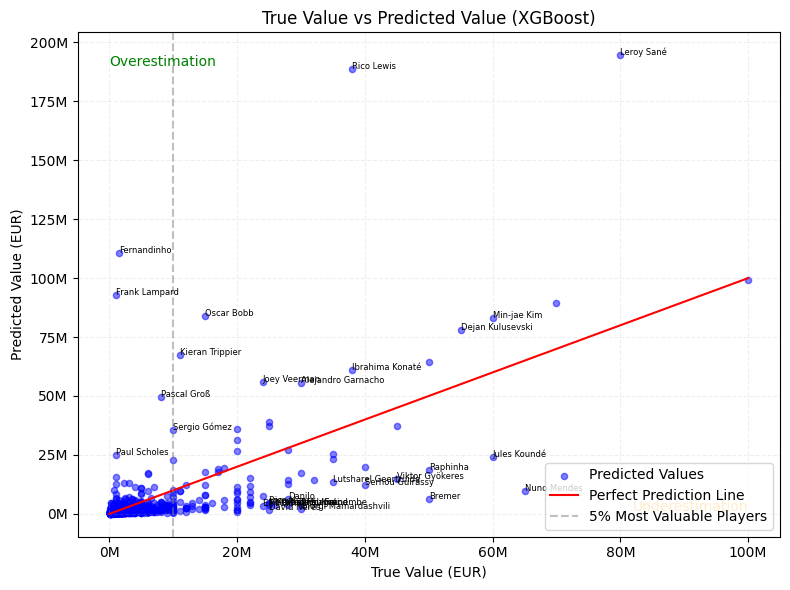

In [ ]:
import numpy as np

# Calculate distances of each point from the optimal line
distances = np.abs(y_pred_original - y_test_original)

# Find the indices of points with maximum distances
max_distance_indices = np.argsort(distances)[-30:]  # Adjust the number to show more or fewer names

# Get the corresponding player names
furthest_names = z.iloc[max_distance_indices]['name'].tolist()

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, y_pred_original, s=20, color='blue', alpha=0.5, marker='o', label='Predicted Values')
plt.xlabel("True Value (EUR)")
plt.ylabel("Predicted Value (EUR)")
plt.title("True Value vs Predicted Value (XGBoost)")
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], color='red', label='Perfect Prediction Line')
plt.text(min(y_test_original), max(y_pred_original), "Overestimation", fontsize=10, color='green', verticalalignment='top', horizontalalignment='left')
plt.text(max(y_test_original), min(y_pred_original), "Underestimation", fontsize=10, color='orange', verticalalignment='bottom', horizontalalignment='right')

# Annotate only the furthest points
for index in max_distance_indices:
    row = z.iloc[index]
    plt.annotate(row['name'], (row['market_value_in_eur'], row['Predicted_Value']), fontsize=6, color='black')

# Set formatter for x-axis and y-axis
def millions_formatter(x, pos):
    return f'{x / 1000000:.0f}M'

# Identify the 1% most valuable players
top_1_percent = z.nlargest(int(len(z) * 0.05), 'market_value_in_eur')
top_1_percent = top_1_percent.sort_values(by='market_value_in_eur')
lowest_value_player = top_1_percent.iloc[0]['market_value_in_eur']
# Add vertical line for the 1% most valuable players
print(lowest_value_player)
plt.axvline(x=lowest_value_player, color='gray', linestyle='--', label='5% Most Valuable Players', alpha=0.5)
    
formatter = FuncFormatter(millions_formatter)
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)

plt.grid(alpha=0.2, linestyle='--', zorder=1)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
XGBRegressor.plot_importance(model)

AttributeError: type object 'XGBRegressor' has no attribute 'plot_importance'